## Imports & Options

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import folium
import branca as bc

In [2]:
# changing display options to see DataFrames better
# pd.options.display.max_rows = 2000
# pd.options.display.max_columns = 2000

## Data

In [3]:
# load in datasets
confirmed_cases_df = pd.read_csv('data/confirmed_cases_malaria.csv')
estimated_cases_df = pd.read_csv('data/estimated_cases_malaria.csv')
estimated_deaths_df = pd.read_csv('data/estimated_deaths_malaria.csv')

In [4]:
geodata = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
geodata.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


## Cleaning DataFrames

### Confirmed Cases DataFrame

In [5]:
# oof. looks like it will need ALL the cleaning
confirmed_cases_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AMR,Americas,Country,BLZ,Belize,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-10T05:00:00.000Z
1,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,EUR,Europe,Country,TJK,Tajikistan,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-10T05:00:00.000Z
2,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AFR,Africa,Country,TCD,Chad,Year,2020,...,NaN,NaN,NaN,NaN,NaN,1 544 194,NaN,NaN,EN,2022-02-10T05:00:00.000Z
3,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,EMR,Eastern Mediterranean,Country,SDN,Sudan,Year,2020,...,NaN,NaN,NaN,NaN,NaN,1 698 394,NaN,NaN,EN,2022-02-10T05:00:00.000Z
4,MALARIA_CONF_CASES,Number of confirmed malaria cases,numeric,AFR,Africa,Country,CAF,Central African Republic,Year,2020,...,NaN,NaN,NaN,NaN,NaN,1 740 970,NaN,NaN,EN,2022-02-10T05:00:00.000Z


In [6]:
confirmed_cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               1057 non-null   object 
 1   Indicator                   1057 non-null   object 
 2   ValueType                   1057 non-null   object 
 3   ParentLocationCode          1057 non-null   object 
 4   ParentLocation              1057 non-null   object 
 5   Location type               1057 non-null   object 
 6   SpatialDimValueCode         1057 non-null   object 
 7   Location                    1057 non-null   object 
 8   Period type                 1057 non-null   object 
 9   Period                      1057 non-null   int64  
 10  IsLatestYear                1057 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [7]:
# many columns contain repeat info. will drop everything we don't need
# example below:
confirmed_cases_df.IndicatorCode.value_counts()

MALARIA_CONF_CASES    1057
Name: IndicatorCode, dtype: int64

In [8]:
confirmed_cases_df.Period.value_counts()

2017    99
2016    99
2015    99
2014    98
2019    97
2018    97
2012    97
2013    96
2011    93
2010    93
2020    89
Name: Period, dtype: int64

In [9]:
# value will need to be cleaned.
confirmed_cases_df.Value[2], confirmed_cases_df.Value[42]

('1\xa0544\xa0194', '254\xa0055')

In [10]:
confirmed_cases_df.Value[2]

'1\xa0544\xa0194'

In [11]:
confirmed_cases_df['conf_case_clean'] = confirmed_cases_df['Value'].apply(
    lambda x: x.replace('\xa0', ''))
confirmed_cases_df['conf_case_clean'].head()

0          0
1          0
2    1544194
3    1698394
4    1740970
Name: conf_case_clean, dtype: object

In [12]:
confirmed_cases_df['conf_case_clean'] = pd.to_numeric(
    confirmed_cases_df['conf_case_clean'])
confirmed_cases_df['conf_case_clean'][2], type(
    confirmed_cases_df['conf_case_clean'][2])

(1544194, numpy.int64)

In [13]:
# Columns we want: SpatialDimValueCode, Location, Period, conf_case_clean
conf_case_clean_df = confirmed_cases_df[[
    'SpatialDimValueCode', 'Location', 'Period', 'conf_case_clean']]
conf_case_clean_df.head()

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970


In [14]:
len(conf_case_clean_df)

1057

In [15]:
conf_case_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
conf_case_clean        0
dtype: int64

In [16]:
conf_case_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  1057 non-null   object
 1   Location             1057 non-null   object
 2   Period               1057 non-null   int64 
 3   conf_case_clean      1057 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 33.2+ KB


In [17]:
# Period: 2010 - 2020
conf_case_clean_df.describe()

,Period,conf_case_clean
count,1057.000000,1.057000e+03
mean,2015.002838,9.817187e+05
std,3.125074,2.516282e+06
min,2010.000000,0.000000e+00
25%,2012.000000,1.163000e+03
50%,2015.000000,2.665700e+04
75%,2018.000000,5.348190e+05
max,2020.000000,2.259065e+07


### Estimated Cases DataFrame

In [18]:
estimated_cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               2334 non-null   object 
 1   Indicator                   2334 non-null   object 
 2   ValueType                   2334 non-null   object 
 3   ParentLocationCode          2334 non-null   object 
 4   ParentLocation              2334 non-null   object 
 5   Location type               2334 non-null   object 
 6   SpatialDimValueCode         2334 non-null   object 
 7   Location                    2334 non-null   object 
 8   Period type                 2334 non-null   object 
 9   Period                      2334 non-null   int64  
 10  IsLatestYear                2334 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [19]:
estimated_cases_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,BLZ,Belize,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
1,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
2,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,ZWE,Zimbabwe,Year,2020,...,NaN,NaN,692000.0,NaN,1649000.0,1 152 901 [692 000 – 1 649 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z
3,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,COG,Congo,Year,2020,...,NaN,NaN,722000.0,NaN,1826000.0,1 176 331 [722 000 – 1 826 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z
4,MALARIA_EST_CASES,Estimated number of malaria cases,text,WPR,Western Pacific,Country,PNG,Papua New Guinea,Year,2020,...,NaN,NaN,1009000.0,NaN,1978000.0,1 470 120 [1 009 000 – 1 978 000],NaN,NaN,EN,2022-02-03T05:00:00.000Z


In [20]:
# Wanted columns: FactValueNumericLow, FactValueNumericHigh, Value

In [21]:
# estimates have high and low values representing bounds of 95% confidence interval
estimated_cases_df.FactValueNumericLow[2], estimated_cases_df.FactValueNumericHigh[2]

(692000.0, 1649000.0)

In [22]:
type(estimated_cases_df.FactValueNumericLow[2]), type(
    estimated_cases_df.FactValueNumericHigh[2])

(numpy.float64, numpy.float64)

In [23]:
# calculating mean estimated cases (probably won't use this. noticed 'Value' has
# the correct info, but will need formatting)
(estimated_cases_df.FactValueNumericLow[2] +
 estimated_cases_df.FactValueNumericHigh[2])/2

1170500.0

In [24]:
estimated_cases_df.Value[2]

'1\xa0152\xa0901 [692\xa0000 – 1\xa0649\xa0000]'

In [25]:
# clean Value column *testing*
estimated_cases_df['Value'].apply(lambda x: x.replace('\xa0', ''))

0                                 0
1                                 0
2        1152901 [692000 – 1649000]
3        1176331 [722000 – 1826000]
4       1470120 [1009000 – 1978000]
                   ...             
2329                          90582
2330       905987 [71000 – 2004000]
2331      929292 [363000 – 2220000]
2332         94271 [73000 – 117000]
2333         94432 [42000 – 150000]
Name: Value, Length: 2334, dtype: object

In [26]:
# split value col after clean to get actual estimate of cases *testing*
estimated_cases_df['Value'].apply(lambda x: x.replace(
    '\xa0', '')).apply(lambda y: y.split(' ')[0])

0             0
1             0
2       1152901
3       1176331
4       1470120
         ...   
2329      90582
2330     905987
2331     929292
2332      94271
2333      94432
Name: Value, Length: 2334, dtype: object

In [27]:
# creating new column of estimated number of cases
estimated_cases_df['est_case_clean'] = estimated_cases_df['Value'].apply(
    lambda x: x.replace('\xa0', '')).apply(lambda y: y.split(' ')[0])
estimated_cases_df['est_case_clean'].head()

0          0
1          0
2    1152901
3    1176331
4    1470120
Name: est_case_clean, dtype: object

In [28]:
# 'No' let's explore what that means
estimated_cases_df['est_case_clean'].value_counts()

0         245
No        110
1          13
6          11
7           8
         ... 
62669       1
62551       1
613         1
611838      1
94432       1
Name: est_case_clean, Length: 1864, dtype: int64

In [29]:
# 'No' appears to be countries without malaria cases reported
estimated_cases_df[estimated_cases_df['est_case_clean'] == 'No']

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified,est_case_clean
84,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,ALB,Albania,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
85,MALARIA_EST_CASES,Estimated number of malaria cases,text,AFR,Africa,Country,DZA,Algeria,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2019,EN,2022-03-03T05:00:00.000Z,No
86,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,AND,Andorra,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
87,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
88,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,ARG,Argentina,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2019,EN,2022-03-03T05:00:00.000Z,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,MALARIA_EST_CASES,Estimated number of malaria cases,text,EMR,Eastern Mediterranean,Country,ARE,United Arab Emirates,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,Certified malaria free 2007,EN,2022-03-03T05:00:00.000Z,No
190,MALARIA_EST_CASES,Estimated number of malaria cases,text,EUR,Europe,Country,GBR,United Kingdom of Great Britain and Northern I...,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
191,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,USA,United States of America,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No
192,MALARIA_EST_CASES,Estimated number of malaria cases,text,AMR,Americas,Country,URY,Uruguay,Year,2020,...,NaN,NaN,NaN,NaN,No malaria,NaN,NaN,EN,2022-03-03T05:00:00.000Z,No


In [30]:
# changing values of 'No' to 0
estimated_cases_df['est_case_clean'] = estimated_cases_df['est_case_clean'].replace([
                                                                                    'No'], '0')

In [31]:
# changing column with pd.to_numeric()
estimated_cases_df['est_case_clean'] = pd.to_numeric(
    estimated_cases_df['est_case_clean'])

In [32]:
# checking the work
estimated_cases_df['est_case_clean'][3], type(
    estimated_cases_df['est_case_clean'][3])

(1176331, numpy.int64)

In [33]:
# Columns we want: SpatialDimValueCode, Location, Period, est_case_clean
est_case_clean_df = estimated_cases_df[[
    'SpatialDimValueCode', 'Location', 'Period', 'est_case_clean']]
est_case_clean_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean
0,BLZ,Belize,2020,0
1,CPV,Cabo Verde,2020,0
2,ZWE,Zimbabwe,2020,1152901
3,COG,Congo,2020,1176331
4,PNG,Papua New Guinea,2020,1470120


In [34]:
len(est_case_clean_df)

2334

In [35]:
est_case_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
est_case_clean         0
dtype: int64

In [36]:
est_case_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  2334 non-null   object
 1   Location             2334 non-null   object
 2   Period               2334 non-null   int64 
 3   est_case_clean       2334 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.1+ KB


In [37]:
est_case_clean_df.describe()

,Period,est_case_clean
count,2334.000000,2.334000e+03
mean,2010.372751,2.126835e+06
std,6.237399,6.332784e+06
min,2000.000000,0.000000e+00
25%,2005.000000,3.837500e+02
50%,2010.000000,4.176450e+04
75%,2016.000000,1.469818e+06
max,2020.000000,6.467796e+07


### Estimated Deaths DataFrame

In [38]:
estimated_deaths_df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AMR,Americas,Country,BLZ,Belize,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
1,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,SEAR,South-East Asia,Country,BTN,Bhutan,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
2,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
3,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,AMR,Americas,Country,CRI,Costa Rica,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z
4,MALARIA_EST_DEATHS,Estimated number of malaria deaths,text,SEAR,South-East Asia,Country,PRK,Democratic People's Republic of Korea,Year,2020,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,EN,2022-02-03T05:00:00.000Z


In [39]:
estimated_deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               2334 non-null   object 
 1   Indicator                   2334 non-null   object 
 2   ValueType                   2334 non-null   object 
 3   ParentLocationCode          2334 non-null   object 
 4   ParentLocation              2334 non-null   object 
 5   Location type               2334 non-null   object 
 6   SpatialDimValueCode         2334 non-null   object 
 7   Location                    2334 non-null   object 
 8   Period type                 2334 non-null   object 
 9   Period                      2334 non-null   int64  
 10  IsLatestYear                2334 non-null   bool   
 11  Dim1 type                   0 non-null      float64
 12  Dim1                        0 non-null      float64
 13  Dim1ValueCode               0 non

In [40]:
estimated_deaths_df['Value'][2333]

'995 [110 – 2880]'

In [41]:
estimated_deaths_df['Value']

0                      0
1                      0
2                      0
3                      0
4                      0
              ...       
2329        89 [2 – 190]
2330       96 [13 – 170]
2331    965 [210 – 2030]
2332        97 [2 – 270]
2333    995 [110 – 2880]
Name: Value, Length: 2334, dtype: object

In [42]:
# creating new column of estimated number of deaths
estimated_deaths_df['est_death_clean'] = estimated_deaths_df['Value'].apply(
    lambda x: x.replace('\xa0', '')).apply(lambda y: y.split(' ')[0])
estimated_deaths_df['est_death_clean']

0         0
1         0
2         0
3         0
4         0
       ... 
2329     89
2330     96
2331    965
2332     97
2333    995
Name: est_death_clean, Length: 2334, dtype: object

In [43]:
estimated_deaths_df['est_death_clean'][18]

'10123'

In [44]:
# changing values of 'No' to 0
estimated_deaths_df['est_death_clean'] = estimated_deaths_df['est_death_clean'].replace([
                                                                                        'No'], '0')

In [45]:
# changing column with pd.to_numeric()
estimated_deaths_df['est_death_clean'] = pd.to_numeric(
    estimated_deaths_df['est_death_clean'])
# checking the work
estimated_deaths_df['est_death_clean'][2333], type(
    estimated_deaths_df['est_death_clean'][2333])

(995, numpy.int64)

In [46]:
# Columns we want: SpatialDimValueCode, Location, Period, value_clean
est_death_clean_df = estimated_deaths_df[[
    'SpatialDimValueCode', 'Location', 'Period', 'est_death_clean']]
est_death_clean_df.head()

,SpatialDimValueCode,Location,Period,est_death_clean
0,BLZ,Belize,2020,0
1,BTN,Bhutan,2020,0
2,CPV,Cabo Verde,2020,0
3,CRI,Costa Rica,2020,0
4,PRK,Democratic People's Republic of Korea,2020,0


In [47]:
len(est_case_clean_df)

2334

In [48]:
# no nulls, good
est_death_clean_df.isna().sum()

SpatialDimValueCode    0
Location               0
Period                 0
est_death_clean        0
dtype: int64

In [49]:
est_death_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SpatialDimValueCode  2334 non-null   object
 1   Location             2334 non-null   object
 2   Period               2334 non-null   int64 
 3   est_death_clean      2334 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 73.1+ KB


In [50]:
# Period: Looks good, years from 2000 - 2020
# est_death_clean: min of 0 deaths, max of 249308 deaths
est_death_clean_df.describe()

,Period,est_death_clean
count,2334.000000,2334.000000
mean,2010.372751,6235.378320
std,6.237399,21909.438954
min,2000.000000,0.000000
25%,2005.000000,0.000000
50%,2010.000000,60.000000
75%,2016.000000,3587.750000
max,2020.000000,249308.000000


## Joining
`est_case_clean_df` & `est_death_clean_df`

In [51]:
est_df = est_case_clean_df.merge(est_death_clean_df)
est_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962


,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962


### Exploring Clean DataFrames

In [52]:
est_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962


In [53]:
len(est_df)

2334

In [54]:
conf_case_clean_df

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970
...,...,...,...,...
1052,PNG,Papua New Guinea,2010,93956
1053,SLE,Sierra Leone,2010,934028
1054,KHM,Cambodia,2010,96464
1055,HND,Honduras,2010,9745


In [55]:
len(conf_case_clean_df)

1057

In [56]:
# sorting by estimated cases
sorted_est_case_df = est_df.sort_values(by='est_case_clean', ascending=False)
sorted_est_case_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
66,NGA,Nigeria,2020,64677959,199689
1453,NGA,Nigeria,2008,62075250,221424
1347,NGA,Nigeria,2009,61757109,210258
285,NGA,Nigeria,2019,60378016,187437
1565,NGA,Nigeria,2007,60355724,229172


In [57]:
sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].Location.head()

66                             Nigeria
38    Democratic Republic of the Congo
13                              Uganda
8                           Mozambique
77                              Angola
Name: Location, dtype: object

In [58]:
def plot_year_top_ten(year, column):
    fig, ax = plt.subplots()
    sns.barplot()

<AxesSubplot: xlabel='Location', ylabel='est_case_clean'>

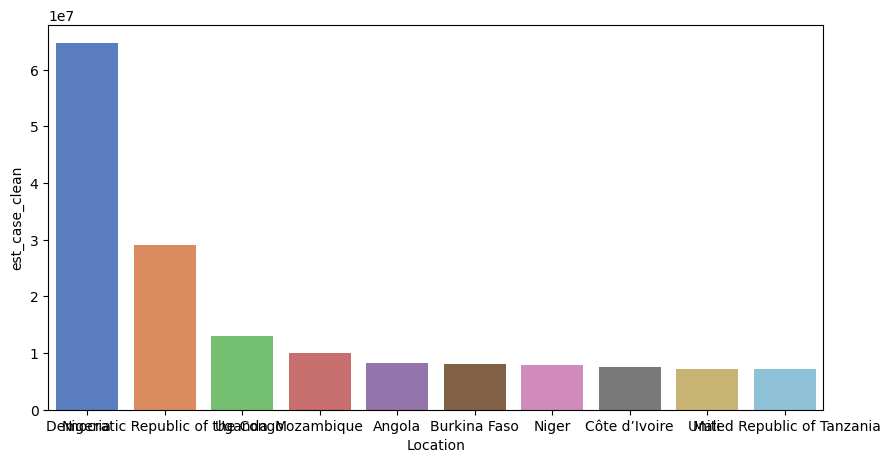

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].Location.head(
    10), y=sorted_est_case_df.loc[sorted_est_case_df['Period'] == 2020].est_case_clean.head(10), palette='muted')

In [60]:
# sorting by estimated deaths
sorted_est_death_df = est_df.sort_values(by='est_death_clean', ascending=False)
sorted_est_death_df.head()

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
2303,NGA,Nigeria,2000,51119378,249308
2204,NGA,Nigeria,2001,51130906,242521
1666,NGA,Nigeria,2006,58577749,232391
2092,NGA,Nigeria,2002,50530444,230496
1777,NGA,Nigeria,2005,56627136,230356


<AxesSubplot: xlabel='Location', ylabel='est_death_clean'>

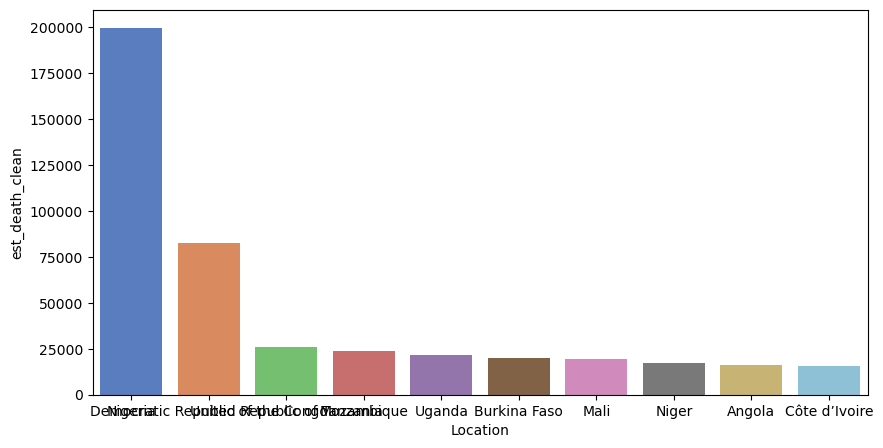

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=sorted_est_death_df.loc[sorted_est_death_df['Period'] == 2020].Location.head(
    10), y=sorted_est_death_df.loc[sorted_est_death_df['Period'] == 2020].est_death_clean.head(10), palette='muted')

<AxesSubplot: xlabel='Period', ylabel='est_case_clean'>

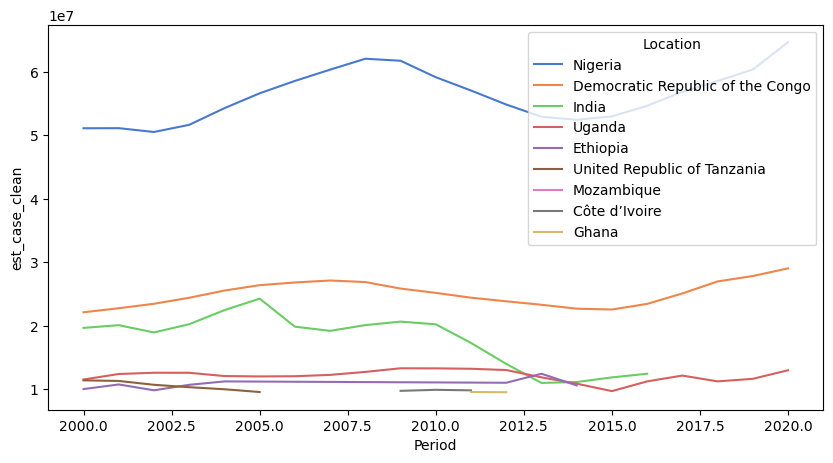

In [62]:
# will need to find a better way to choose which countries to include
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_case_df.head(100), x='Period',
             y='est_case_clean', hue='Location', palette='muted')

In [63]:
# top 10 countries by est death
list(sorted_est_death_df.loc[sorted_est_death_df['Period']
     == 2020].SpatialDimValueCode.head(10))

['NGA', 'COD', 'TZA', 'MOZ', 'UGA', 'BFA', 'MLI', 'NER', 'AGO', 'CIV']

In [64]:
sorted_est_death_df.loc[sorted_est_death_df['SpatialDimValueCode'].isin(
    ['NGA', 'COD', 'TZA', 'MOZ', 'UGA', 'BFA', 'MLI', 'NER', 'AGO', 'CIV'])]

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
2303,NGA,Nigeria,2000,51119378,249308
2204,NGA,Nigeria,2001,51130906,242521
1666,NGA,Nigeria,2006,58577749,232391
2092,NGA,Nigeria,2002,50530444,230496
1777,NGA,Nigeria,2005,56627136,230356
...,...,...,...,...,...
804,AGO,Angola,2014,4493340,12036
822,CIV,Côte d’Ivoire,2014,6012351,11943
1104,AGO,Angola,2011,3806828,11832
896,AGO,Angola,2013,4180694,11586


<AxesSubplot: xlabel='Period', ylabel='est_case_clean'>

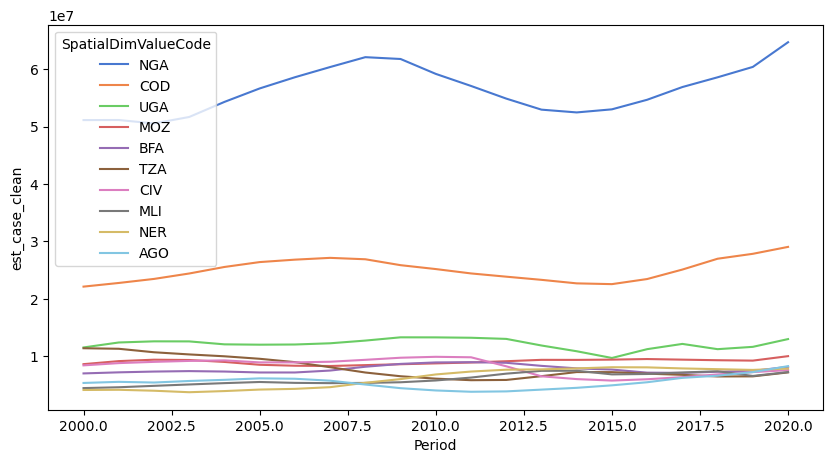

In [65]:
# plotting estimated cases 2000-2020

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['SpatialDimValueCode'].isin(
    ['NGA', 'COD', 'TZA', 'MOZ', 'UGA', 'BFA', 'MLI', 'NER', 'AGO', 'CIV'])], x='Period', y='est_case_clean', hue='SpatialDimValueCode', palette='muted')

<AxesSubplot: xlabel='Period', ylabel='est_case_clean'>

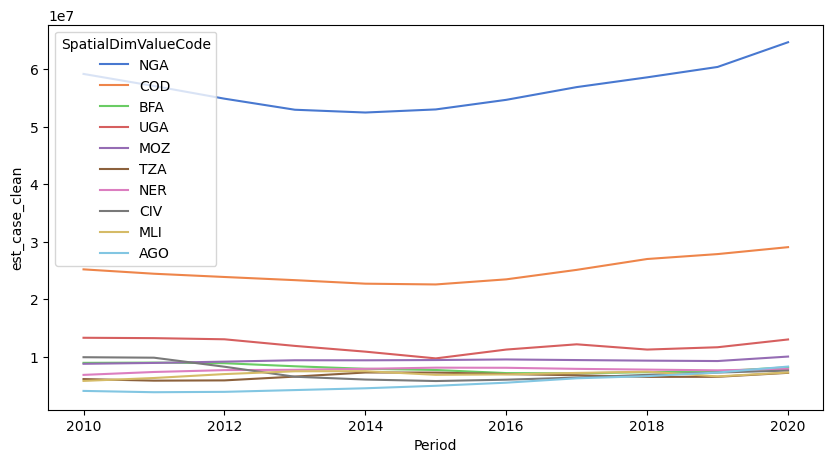

In [66]:
# plotting estimated cases 2010-2020
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['SpatialDimValueCode'].isin(['NGA', 'COD', 'TZA', 'MOZ', 'UGA', 'BFA', 'MLI', 'NER', 'AGO', 'CIV'])
                                          ].loc[sorted_est_death_df['Period'].isin(range(2010, 2021))], x='Period', y='est_case_clean', hue='SpatialDimValueCode', palette='muted')

<AxesSubplot: xlabel='Period', ylabel='est_death_clean'>

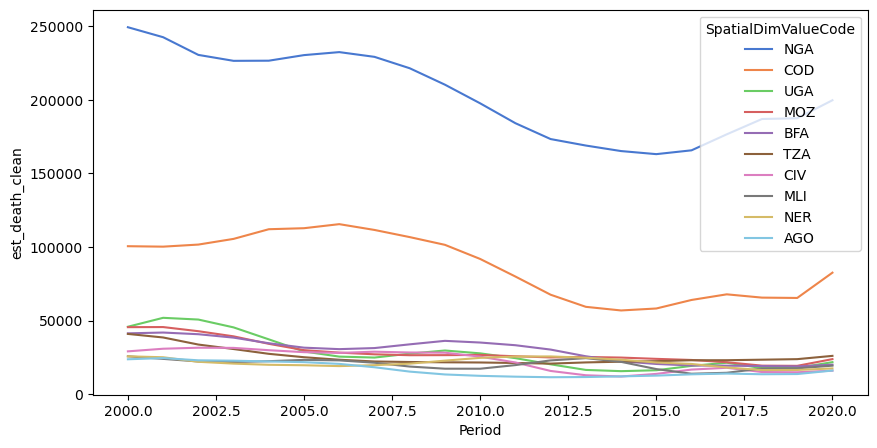

In [67]:
# plotting estimated deaths 2000-2020
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['Location'].isin(['Nigeria',
                                                                                'Democratic Republic of the Congo',
                                                                                'United Republic of Tanzania',
                                                                                'Mozambique',
                                                                                'Uganda',
                                                                                'Burkina Faso',
                                                                                'Mali',
                                                                                'Niger',
                                                                                'Angola',
                                                                                'Côte d’Ivoire'])], x='Period', y='est_death_clean', hue='SpatialDimValueCode', palette='muted')

<AxesSubplot: xlabel='Period', ylabel='est_death_clean'>

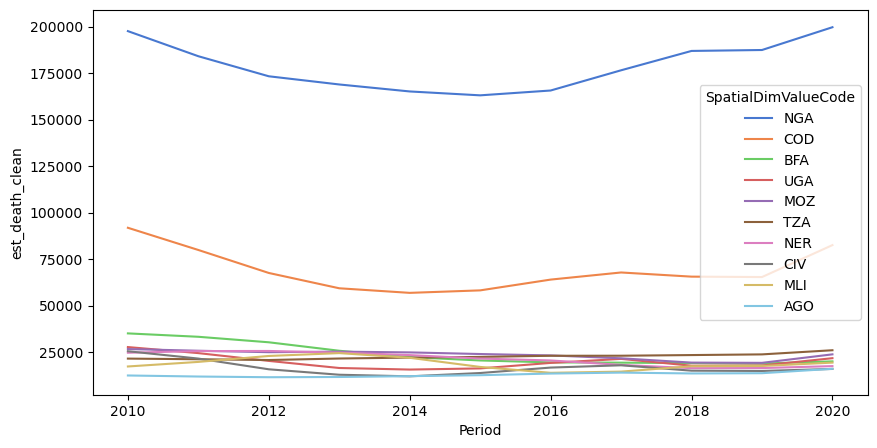

In [68]:
# plotting estimated deaths 2010-2020
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=sorted_est_death_df.loc[sorted_est_death_df['Location'].isin(['Nigeria',
                                                    'Democratic Republic of the Congo',
                                                    'United Republic of Tanzania',
                                                    'Mozambique',
                                                    'Uganda',
                                                    'Burkina Faso',
                                                    'Mali',
                                                    'Niger',
                                                    'Angola',
                                                    'Côte d’Ivoire'])].loc[sorted_est_death_df['Period'].isin(range(2010, 2021))], x='Period', y='est_death_clean', hue='SpatialDimValueCode', palette='muted')

In [69]:
conf_case_clean_df.head()

,SpatialDimValueCode,Location,Period,conf_case_clean
0,BLZ,Belize,2020,0
1,TJK,Tajikistan,2020,0
2,TCD,Chad,2020,1544194
3,SDN,Sudan,2020,1698394
4,CAF,Central African Republic,2020,1740970


In [70]:
conf_case_clean_df.loc[conf_case_clean_df['Location'].isin(['Nigeria',
                                                            'Democratic Republic of the Congo',
                                                            'United Republic of Tanzania',
                                                            'Mozambique',
                                                            'Uganda',
                                                            'Burkina Faso',
                                                            'Mali',
                                                            'Niger',
                                                            'Angola',
                                                            'Côte d’Ivoire'])].head()

,SpatialDimValueCode,Location,Period,conf_case_clean
8,BFA,Burkina Faso,2020,10600340
13,MOZ,Mozambique,2020,11318685
18,UGA,Uganda,2020,14196657
26,NGA,Nigeria,2020,18325240
34,MLI,Mali,2020,2666266


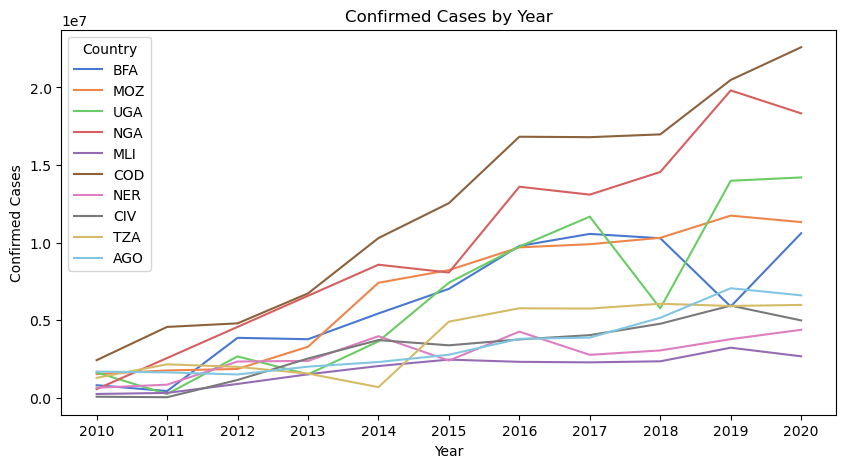

In [71]:
# plotting confirmed cases
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=conf_case_clean_df.loc[conf_case_clean_df['Location'].isin(['Nigeria',
                                                                              'Democratic Republic of the Congo',
                                                                              'United Republic of Tanzania',
                                                                              'Mozambique',
                                                                              'Uganda',
                                                                              'Burkina Faso',
                                                                              'Mali',
                                                                              'Niger',
                                                                              'Angola',
                                                                              'Côte d’Ivoire'])], x='Period', y='conf_case_clean', hue='SpatialDimValueCode', palette='muted')
ax.legend(title='Country')
ax.set_title('Confirmed Cases by Year')
ax.set_ylabel('Confirmed Cases')
ax.set_xlabel('Year')
ax.set_xticks(ticks=range(2010, 2021))
plt.show()

In [72]:
# total of confirmed cases, 2010-2020
conf_cases_2010_to_2020 = conf_case_clean_df.conf_case_clean.sum()
conf_cases_2010_to_2020

1037676633

In [73]:
# total estimated cases 2010 - 2020
est_cases_2010_to_2020 = est_df['est_case_clean'].loc[est_df['Period'].isin(
    range(2010, 2021))].sum()
est_cases_2010_to_2020

2540102011

In [74]:
# total of estimated cases, 2000-2020
est_df.est_case_clean.sum()

4964033737

In [75]:
# total estimated deaths 2010 - 2020
est_deaths_2010_to_2020 = est_df['est_death_clean'].loc[est_df['Period'].isin(
    range(2010, 2021))].sum()
est_deaths_2010_to_2020

6557521

In [76]:
# total of estimated deaths, 2000-2020
est_df.est_death_clean.sum()

14553373

In [77]:
# percent of estimated # deaths/ estimated # cases from 2010-2020
print(
    f'(Estimated) Deaths per Case from 2010-2020: {round(est_deaths_2010_to_2020/est_cases_2010_to_2020*100, 2)}%')

(Estimated) Deaths per Case from 2010-2020: 0.26%


In [78]:
# percent of confirmed cases to estimated cases 2010-2020
print(
    f'Percent of Confirmed Cases: {round(conf_cases_2010_to_2020/est_cases_2010_to_2020*100, 2)}%')

Percent of Confirmed Cases: 40.85%


### GeoData

In [79]:
geodata.continent.value_counts()

Africa                     51
Asia                       47
Europe                     39
North America              18
South America              13
Oceania                     7
Seven seas (open ocean)     1
Antarctica                  1
Name: continent, dtype: int64

In [80]:
geodata

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [81]:
# isolate all land except Antarctica
world = geodata.loc[geodata['continent'] != 'Antarctica']

In [82]:
geodata.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [83]:
# isolating countries needed

nigeria = geodata.loc[geodata['name'] == 'Nigeria']
dem_rep_congo = geodata.loc[geodata['name'] == 'Congo']
tanzania = geodata.loc[geodata['name'] == 'Tanzania']
mozambique = geodata.loc[geodata['name'] == 'Mozambique']
uganda = geodata.loc[geodata['name'] == 'Uganda']
burkina_faso = geodata.loc[geodata['name'] == 'Burkina Faso']
mali = geodata.loc[geodata['name'] == 'Mali']
niger = geodata.loc[geodata['name'] == 'Niger']
angola = geodata.loc[geodata['name'] == 'Angola']
c_ivoire = geodata.loc[geodata['iso_a3'] == "CIV"]

In [84]:
# list
countries = [nigeria, dem_rep_congo, tanzania, mozambique,
             uganda, burkina_faso, mali, niger, angola, c_ivoire]

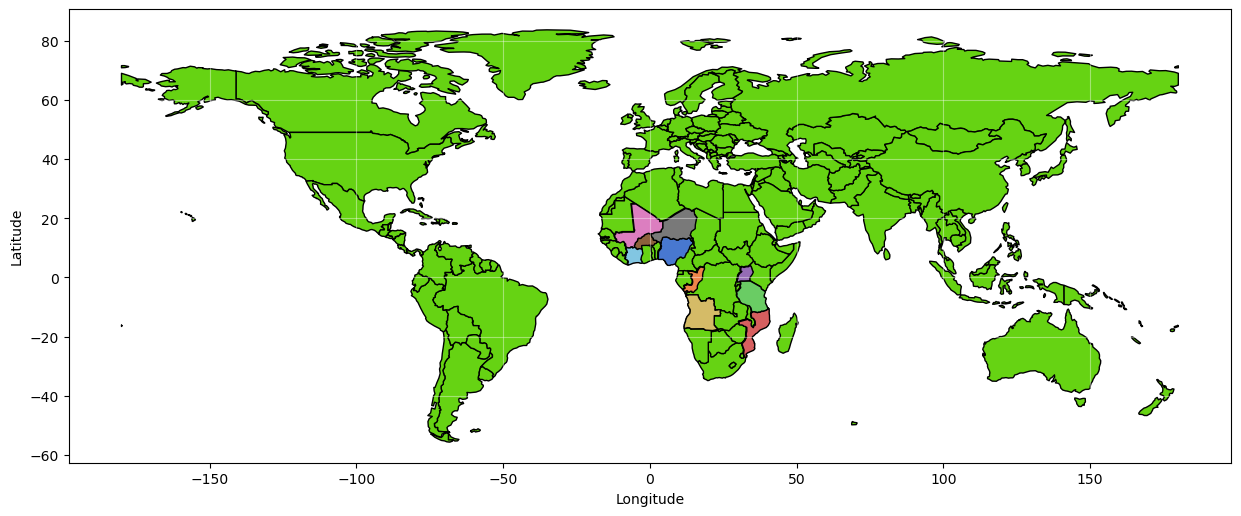

In [85]:
# only Africa is needed
fig2, ax2 = plt.subplots(figsize=(15, 15))

world.plot(color='#66d313',
           edgecolor='black',
           ax=ax2)

nigeria.plot(color='#4878d0', edgecolor='black', ax=ax2)
dem_rep_congo.plot(color='#ee854a', edgecolor='black', ax=ax2)
tanzania.plot(color='#6acc64', edgecolor='black', ax=ax2)
mozambique.plot(color='#d65f5f', edgecolor='black', ax=ax2)
uganda.plot(color='#956cb4', edgecolor='black', ax=ax2)
burkina_faso.plot(color='#8c613c', edgecolor='black', ax=ax2)
mali.plot(color='#dc7ec0', edgecolor='black', ax=ax2)
niger.plot(color='#797979', edgecolor='black', ax=ax2)
angola.plot(color='#d5bb67', edgecolor='black', ax=ax2)
c_ivoire.plot(color='#82c6e2', edgecolor='black', ax=ax2)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(visible=True, color='white', alpha=.4)
plt.show()

In [86]:
africa = geodata.loc[geodata['continent'] == 'Africa']
africa.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
11,86790567.0,Africa,Dem. Rep. Congo,COD,50400,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
12,10192317.3,Africa,Somalia,SOM,4719,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829..."
13,52573973.0,Africa,Kenya,KEN,95503,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."


In [87]:
top_10_geo = geodata.loc[geodata['iso_a3'].isin(
    ['NGA', 'COD', 'TZA', 'MOZ', 'UGA', 'BFA', 'MLI', 'NER', 'AGO', 'CIV'])]

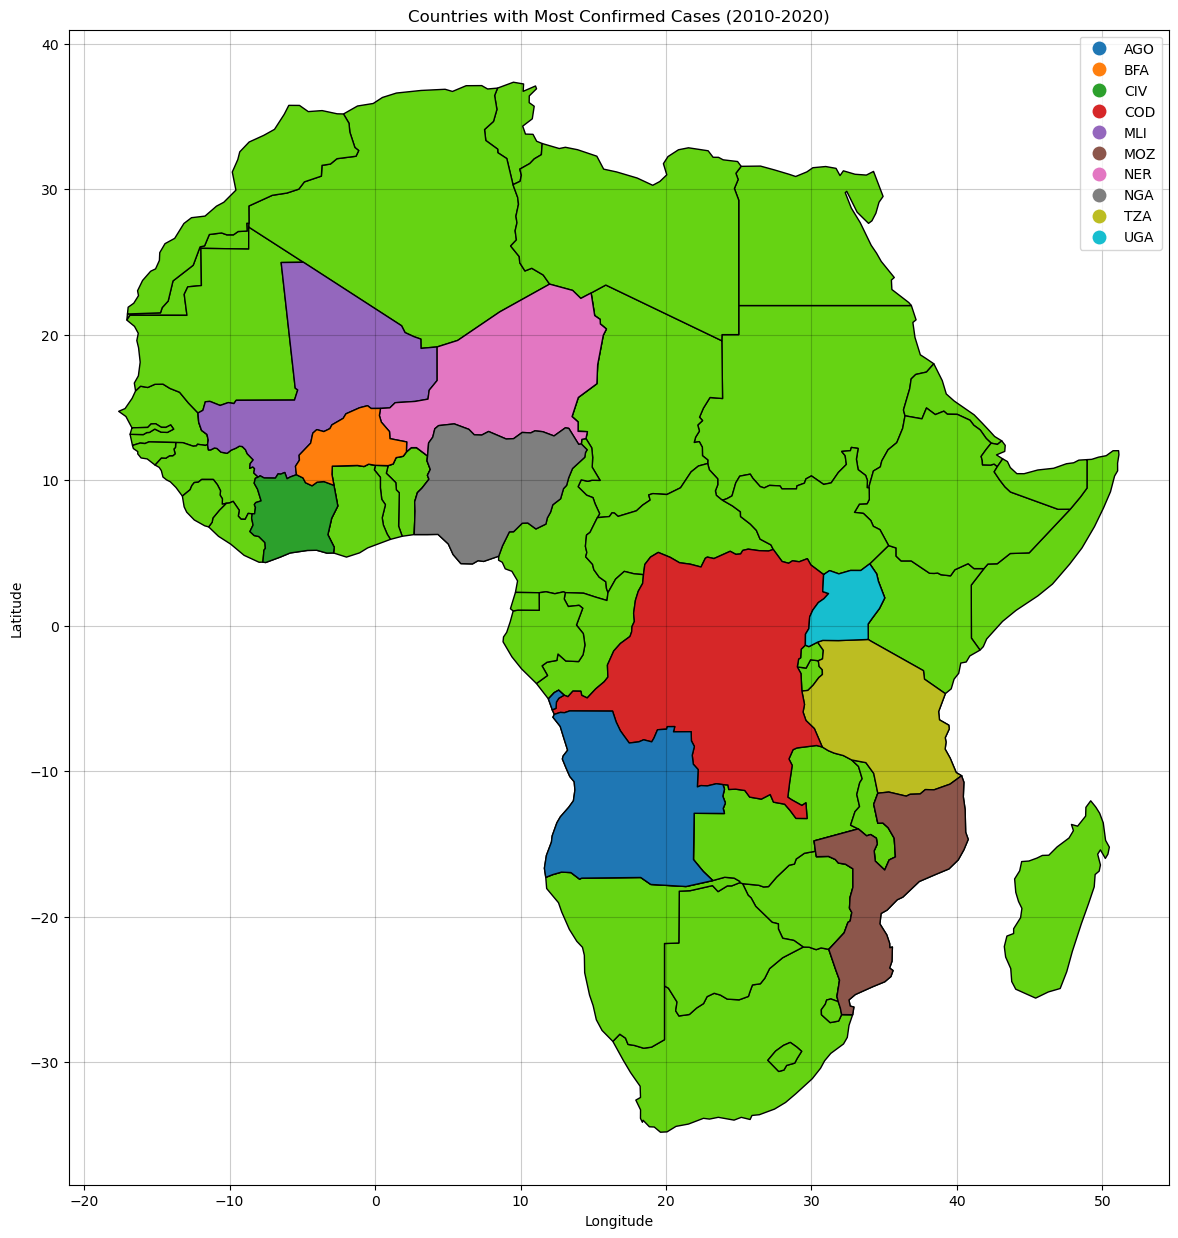

In [88]:
fig2, ax2 = plt.subplots(figsize=(15, 15))

africa.plot(color='#66d313',
            edgecolor='black',
            ax=ax2, label='')

top_10_geo.plot(edgecolor='black', ax=ax2, label='Nigeria',
                column='iso_a3', legend='True', )

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(visible=True, color='black', alpha=.2)
ax2.set_title('Countries with Most Confirmed Cases (2010-2020)')
plt.show()

In [89]:
needed_4_geo = geodata.loc[geodata['iso_a3'].isin(
    ['NGA', 'COD', 'TZA', 'NER'])]

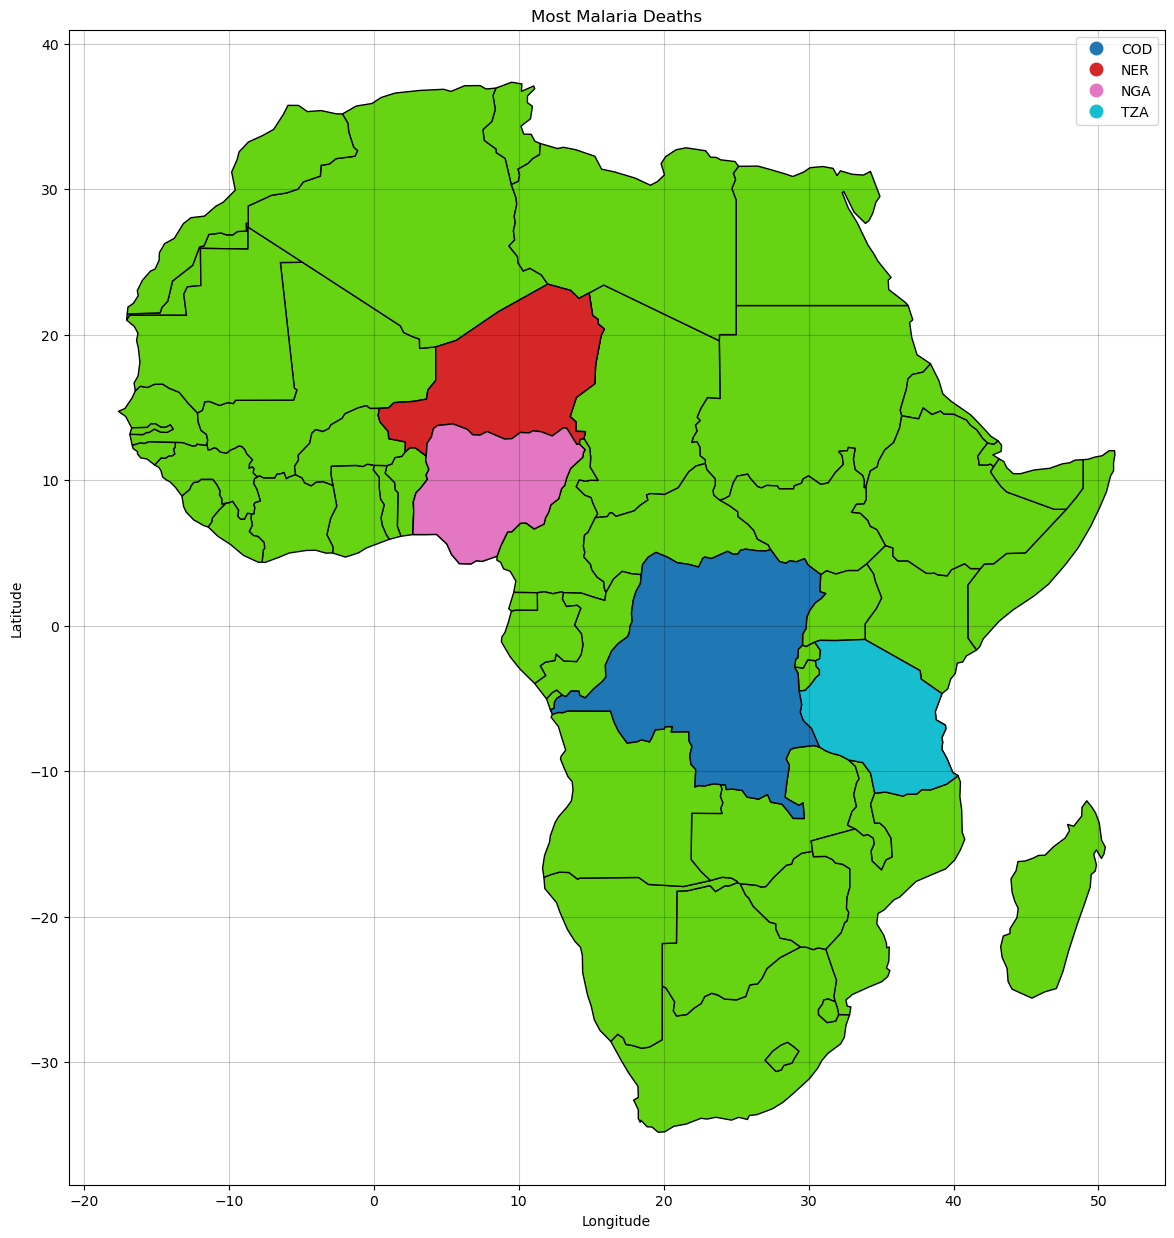

In [90]:
fig2, ax2 = plt.subplots(figsize=(15, 15))

africa.plot(color='#66d313',
            edgecolor='black',
            ax=ax2, label='')

needed_4_geo.plot(edgecolor='black', ax=ax2, label='Nigeria',
                column='iso_a3', legend='True', )

ax2.set_title('Most Malaria Deaths')

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(visible=True, color='black', alpha=.2)
plt.show()

### Data by Year

In [91]:
est_df.groupby(by='Period')
est_df

,SpatialDimValueCode,Location,Period,est_case_clean,est_death_clean
0,BLZ,Belize,2020,0,0
1,CPV,Cabo Verde,2020,0,0
2,ZWE,Zimbabwe,2020,1152901,2951
3,COG,Congo,2020,1176331,2354
4,PNG,Papua New Guinea,2020,1470120,2962
...,...,...,...,...,...
2329,PRK,Democratic People's Republic of Korea,2000,90582,0
2330,MDG,Madagascar,2000,905987,2239
2331,PAK,Pakistan,2000,929292,995
2332,PER,Peru,2000,94271,96


In [92]:
est_df.Period.value_counts()

2020    194
2009    107
2001    107
2002    107
2003    107
2004    107
2005    107
2006    107
2007    107
2008    107
2010    107
2019    107
2011    107
2012    107
2013    107
2014    107
2015    107
2016    107
2017    107
2018    107
2000    107
Name: Period, dtype: int64

In [93]:
est_df.loc[est_df['Period'] == 2020]['est_case_clean'].sum()

241078279

In [94]:
year_list = []
est_cases_by_year = []
est_deaths_by_year = []

for i in range(2000, 2021):
    year_list.append(i)
    est_cases_by_year.append(
        est_df.loc[est_df['Period'] == i]['est_case_clean'].sum())
    est_deaths_by_year.append(
        est_df.loc[est_df['Period'] == i]['est_death_clean'].sum())

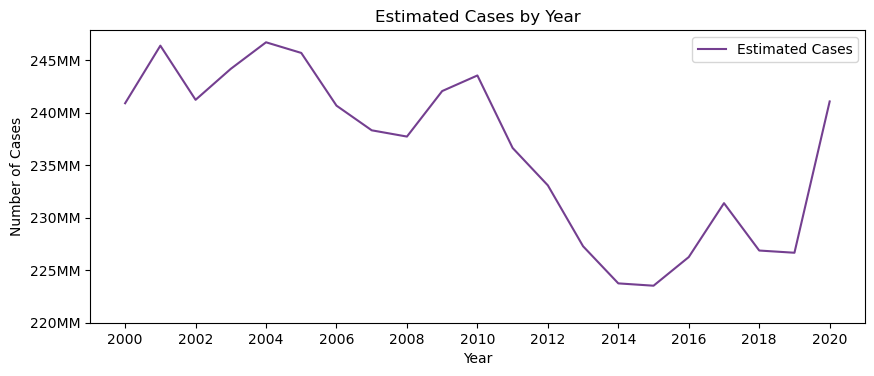

In [130]:
# estimated cases by year 2000-2020

fig, ax = plt.subplots(figsize=(10, 3.8))

sns.lineplot(x=year_list, y=est_cases_by_year, ax=ax, label='Estimated Cases', color='#743f90')

ax.set_title('Estimated Cases by Year')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_xticks(ticks=range(2000, 2021, 2))
ax.set_yticks(ticks=range(220000000, 250000000, 5000000))
ax.set_yticklabels(labels=('220MM', '225MM', '230MM', '235MM', '240MM', '245MM'))
plt.show()

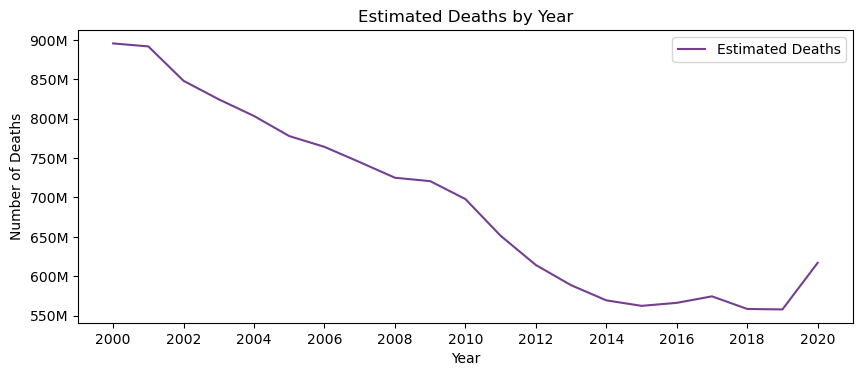

In [131]:
# estimated deaths by year 2000-2020

fig, ax = plt.subplots(figsize=(10, 3.8))

sns.lineplot(x=year_list, y=est_deaths_by_year,
             ax=ax, label='Estimated Deaths', color='#743F90')

ax.set_title('Estimated Deaths by Year')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Deaths')
ax.set_xticks(ticks=range(2000, 2021, 2))
ax.set_yticks(ticks=range(550000, 950000, 50000))
ax.set_yticklabels(labels=('550M', '600M', '650M', '700M', '750M', '800M', '850M', '900M'))
plt.show()

In [97]:
conf_cases_by_year = []

for i in year_list:
    conf_cases_by_year.append(
        conf_case_clean_df.loc[conf_case_clean_df['Period'] == i]['conf_case_clean'].sum())

In [98]:
conf_cases_by_year

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 26334387,
 26920114,
 42861242,
 50055944,
 82651029,
 99763618,
 130054506,
 138789501,
 126346009,
 159709043,
 154191240]

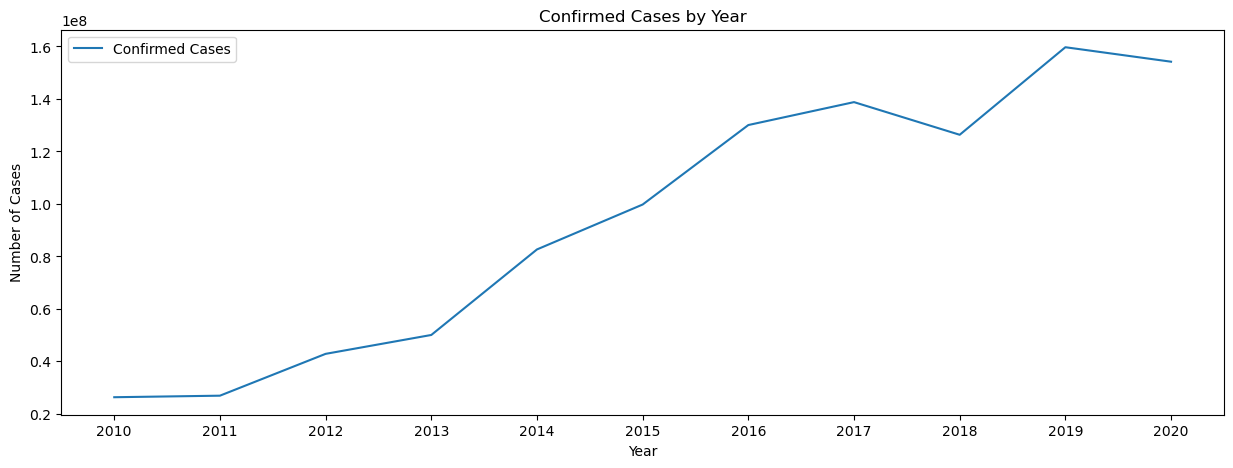

In [99]:
# confirmed cases by year 2010-2020

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(x=year_list[-11:], y=conf_cases_by_year[-11:],
             ax=ax, label='Confirmed Cases')

ax.set_title('Confirmed Cases by Year')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_xticks(ticks=range(2010, 2021, 1))
plt.show()

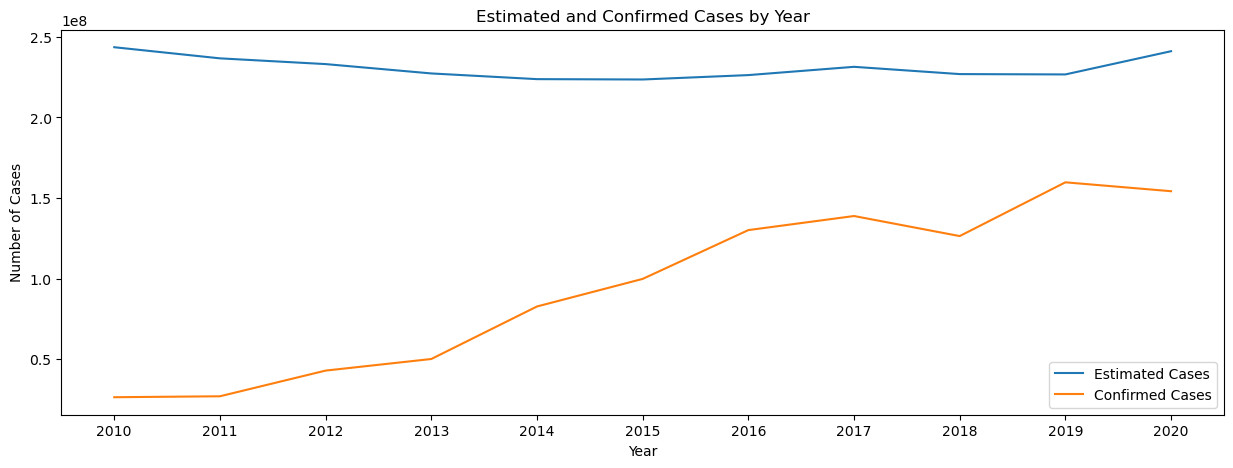

In [100]:
# estimated and confirmed cases by year

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(x=year_list[-11:], y=est_cases_by_year[-11:],
             ax=ax, label='Estimated Cases')
sns.lineplot(x=year_list[-11:], y=conf_cases_by_year[-11:],
             ax=ax, label='Confirmed Cases')

ax.set_title('Estimated and Confirmed Cases by Year')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_xticks(ticks=range(2010, 2021, 1))
plt.show()